# Расчет затрубного пространства

версия 0.1 от 20.05.2020


In [1]:
# подготовимся к импорту API который находится в родительской папке относительно этой тетрадки
import sys
sys.path.insert(0,'..')
import pandas as pd
# импортируем api
import unifloc_vba_python_api.python_api as python_api 
# готовим объект с доступом к надстройке. При этом надстройка откроется и запустится excel 
UniflocVBA = python_api.API("../UniflocVBA_7.xlam")
print("import excel with unifloc vba done. version " + UniflocVBA.unf_version())

import excel with unifloc vba done. version 7.24


In [2]:
import matplotlib.pyplot as plt
#%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

## Описание алгоритма расчета затрубного пространства

Основная функция для использования: `MF_p_pipeline_atma`
Функция возвращает несколько tuples (неизменяемых списков python), при этом количество данных в выводе может варьироваться по усмотрению пользователя

Чтобы определить динамический уровень в затрубе нужно:

1. Построить КРД снизу-вверх для столба жидкости от давления на приеме (давления на башмаке). При этом нужно учесть, что в затрубном пространстве находится чистая нефть и дебит равен нулю - идет барботаж газа через неподвижный столб жидкости. Расход газа можно задать вручную через q_gas_sm3day
2. Построить КРД сверху-вниз для газа от давления в затрубном пространстве. (При этом затрубное давление примерно равно линейному (без учета давления открытия обратного клапана в затрубе), поэтому можно пользоваться также им)
3. Пересечение КРД1 и КРД2 даст значение динамического уровня. При этом, если пересечения нет или динамический уровень отрицательный, то происходит фонтанирование скважины через затруб. Фонтарирование через затруб - поднятие жидкости в затрубе за счет снижение ее плотности до устья и излив ее. При ФЧЗ исходный алгоритм расчета будет неверным - нужно будет учитывать какая доля жидкости пошла в НКТ, какая в затруб и считать распределения давления по двум путям совместно.

Зададим исходные данные по флюиду с помощью словаря

Обычная стандартная PVT строка без сепарации

In [3]:
pvt_str_data_oil_annulus = {"gamma_gas":0.6,
"gamma_oil":0.86,
"gamma_wat":1,
"rsb_m3m3":100,
"rp_m3m3":-1,
"pb_atma":-1,
"tres_C":90,
"bob_m3m3":-1,
"muob_cP":-1,
"PVTcorr":0,
"ksep_fr":0,
"p_ksep_atma":-1,
"t_ksep_C":-1,
"gas_only":False
               }

Зададим свойства для расчета КРД для неподвижной жидкости

In [4]:
pipeline_data_oil_annulus = {"p_calc_from_atma": 50,
"t_calc_from_C": 50,
"t_val":20,
"h_list_m" : 2000,
"diam_list_mm" : 50,
"qliq_sm3day" : 0,
"fw_perc":0,
"q_gas_sm3day":0,
"str_PVT":UniflocVBA.PVT_encode_string(**pvt_str_data_oil_annulus),
"calc_flow_direction":0,
"hydr_corr":0,
"temp_method":1,
"c_calibr":1,
"roughness_m":0.0001,
"out_curves":2,
"out_curves_num_points":10}

Также для удобства напишем функцию, для обработки исходной выдачи функции MF_p_pipeline_atma

In [5]:
def covert_vba_result(vba_result, option=0):
    if option == 0: #возвращаем только рассчитанные давление и температуру
        result = vba_result[0][0], vba_result[0][1]
    elif option == 1:
        result = pd.DataFrame(vba_result) #возвращает необработанный DataFrame
    elif option == 2: #возвращает обработанный DataFrame с распределением свойств
        result = pd.DataFrame(vba_result)
        result.columns = result[result.index==2].iloc[0]
        result = result[result.index>2]
        result = result.set_index('hvert,m')
    return result    

Напишем функцию для расчета затрубного пространства

In [6]:
def calc_annulus(pvt_str_data_oil_annulus, pipeline_data_oil_annulus, p_calc_annulus_atma, debug_mode=False):
    """
    Функция для расчета затрубного простанства и нахождения динамического уровня.
    Расход газа в затрубе нужно задавать вручную
    Считается КРД1 снизу-вверх барботаж газа через столб нефти
    Считается КРД2 сверху-вниз для газа
    По пересечению КРД1 и КРД2 находится динамический уровень
    
    pvt_str_data_oil_annulus: словарь для pvt свойств жидкости в затрубе
    pipeline_data_oil_annulus: словарь для MF_p_pipeline_atma 
    p_calc_annulus_atma: давление в затрубном пространства
    
    """
    
    pvt_str_data_gas_annulus = pvt_str_data_oil_annulus.copy()
    pvt_str_data_gas_annulus['gas_only'] = 1
    pvt_str_annulus = UniflocVBA.PVT_encode_string(**pvt_str_data_gas_annulus)

    pipeline_data_gas_annulus = pipeline_data_oil_annulus.copy()
    pipeline_data_gas_annulus["str_PVT"] = pvt_str_annulus
    pipeline_data_gas_annulus["t_val"] = pipeline_data_oil_annulus["t_calc_from_C"]
    pipeline_data_gas_annulus["t_calc_from_C"] = pipeline_data_oil_annulus["t_val"]

    pipeline_data_gas_annulus['p_calc_from_atma'] = p_calc_annulus_atma
    pipeline_data_gas_annulus['calc_flow_direction'] = 10
    
    if debug_mode:
        print('\n')
        print('level0: calc_annulus')
        print(pvt_str_data_oil_annulus)
        print(pipeline_data_oil_annulus)
    
    vba_result_oil_annulus = covert_vba_result(UniflocVBA.MF_p_pipeline_atma(**pipeline_data_oil_annulus),2)
    vba_result_gas_annulus = covert_vba_result(UniflocVBA.MF_p_pipeline_atma(**pipeline_data_gas_annulus),2)
    
    this_hdyn_m = UniflocVBA.crv_intersection(vba_result_oil_annulus.index.values * (-1),   vba_result_oil_annulus['p,atma'].values, 
                           vba_result_gas_annulus.index.values * (-1),   vba_result_gas_annulus['p,atma'].values)
    
    if this_hdyn_m[0] >0:
        print(f"Обнаружен фонтан через затруб для qgas_sm3day = {pipeline_data_gas_annulus['q_gas_sm3day']}" )
    return vba_result_oil_annulus, vba_result_gas_annulus, this_hdyn_m

Проверим на работоспособность

In [7]:
vba_result_oil_annulus, vba_result_gas_annulus, this_hdyn_m = calc_annulus(pvt_str_data_oil_annulus, pipeline_data_oil_annulus, 20)
this_hdyn_m

(-1654.1104198925489,)

Теперь будем изменять количество газа, поступающее в затрубное пространство, чтобы узнать, как при этом изменится динамический уровень

Для q_gas_sm3day = 0 динамический уровень, м = (-1654.1104198925489,)
Для q_gas_sm3day = 500 динамический уровень, м = (-1512.789253687085,)
Для q_gas_sm3day = 1000 динамический уровень, м = (-1379.7020049024313,)
Для q_gas_sm3day = 1500 динамический уровень, м = (-1176.2800282067424,)


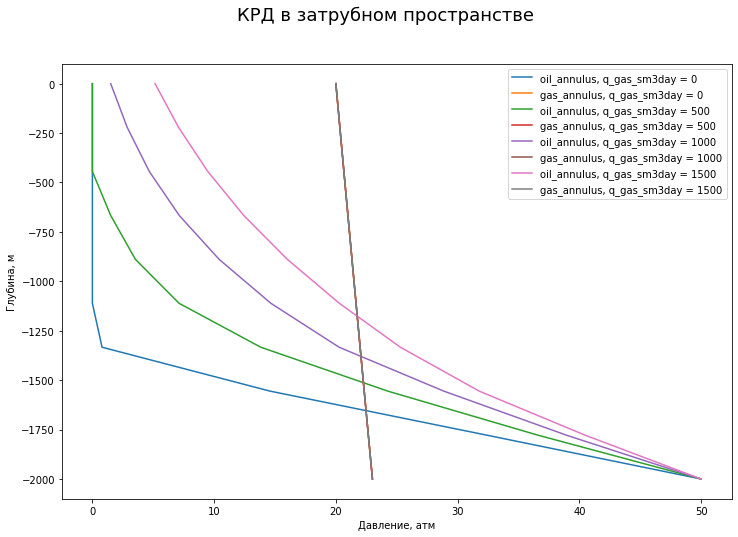

In [8]:
fig = plt.figure()
for i in range(0, 2000, 500):
    pipeline_data_oil_annulus['q_gas_sm3day'] = i
    vba_result_oil_annulus, vba_result_gas_annulus, this_hdyn_m = calc_annulus(pvt_str_data_oil_annulus, pipeline_data_oil_annulus, 20)
    plt.plot(vba_result_oil_annulus['p,atma'], vba_result_oil_annulus.index * (-1), label = f"oil_annulus, q_gas_sm3day = {i}")
    plt.plot(vba_result_gas_annulus['p,atma'], vba_result_gas_annulus.index * (-1), label = f"gas_annulus, q_gas_sm3day = {i}")
    print(f"Для q_gas_sm3day = {i} динамический уровень, м = {this_hdyn_m}")
plt.legend(loc='upper right')
plt.xlabel('Давление, атм')
plt.ylabel('Глубина, м')
fig.suptitle(f"КРД в затрубном пространстве", fontsize = 18)
plt.show()

При большем количестве газа динамический уровень становится меньше, что логично

Минус данного расчета в том, что мы вручную задаем количество газа, поступающего в затрубное пространство.

Напишем функцию, которая будет его расчитывать при данных P,T, расхода жидкости, обводненности и коэффициента сепарации

Это будет полезно для расчета затруба при работе ЭЦН

In [9]:
def calc_annulus_with_sep(pvt_str_data_oil_annulus, pipeline_data_oil_annulus,
                          p_calc_annulus_atma, ksep_d, qliq_sm3day, fw_perc, debug_mode=False):
    """
    Функция для расчета затрубного простанства и нахождения динамического уровня.
    Расход газа в затрубе считается с учетом сепарации
    
    Для давления на приеме ЭЦН (башмаке НКТ) рассчитывается сепарация и количество газа, поступившее в затрубное пространство
    
    Далее вызывается функция calc_annulus, где для найденного расхода газа в затрубном пространстве:
    Считается КРД1 снизу-вверх барботаж газа через столб нефти
    Считается КРД2 сверху-вниз для газа
    По пересечению КРД1 и КРД2 находится динамический уровень
    
    pvt_str_data_oil_annulus: словарь для pvt свойств жидкости в затрубе
    pipeline_data_oil_annulus: словарь для MF_p_pipeline_atma 
    p_calc_annulus_atma: давление в затрубном пространства
    ksep_d: коэффициент сепарации, д.ед.
    qliq_sm3day: дебит жидкости в поверхностных условиях, м3/сут
    fw_perc: обводненность, %
    """
    
        
    
    #определим давление и температуру сепарации
    p_intake_atma = pipeline_data_oil_annulus['p_calc_from_atma'] 
    t_intake_c = pipeline_data_oil_annulus['t_calc_from_C']
    
    #создадим флюид, в котором будет учет сепарации
    pvt_str_data_oil_annulus_with_sep = pvt_str_data_oil_annulus.copy()
    pvt_str_data_oil_annulus_with_sep['p_ksep_atma'] = p_intake_atma
    pvt_str_data_oil_annulus_with_sep['t_ksep_C'] = t_intake_c
    pvt_str_data_oil_annulus_with_sep['ksep_fr'] = ksep_d
    
    #посчитаем расход ГЖС до и после сепарации
    qmix_intake_before_sep_m3day = UniflocVBA.MF_q_mix_rc_m3day(qliq_sm3day, fw_perc, p_intake_atma, t_intake_c,
                                                            UniflocVBA.PVT_encode_string(**pvt_str_data_oil_annulus))

    qmix_intake_after_sep_m3day = UniflocVBA.MF_q_mix_rc_m3day(qliq_sm3day, fw_perc,  p_intake_atma, t_intake_c, 
                                                            UniflocVBA.PVT_encode_string(**pvt_str_data_oil_annulus_with_sep))
    #посчитаем долю газа в потоке до и после сепарации
    gas_fraction_before_sep = UniflocVBA.MF_gas_fraction_d(p_intake_atma, t_intake_c, fw_perc,
                                                       str_PVT = UniflocVBA.PVT_encode_string(**pvt_str_data_oil_annulus))

    gas_fraction_after_sep = UniflocVBA.MF_gas_fraction_d(p_intake_atma, t_intake_c, fw_perc,
                                                      str_PVT = UniflocVBA.PVT_encode_string(**pvt_str_data_oil_annulus_with_sep))

    #посчитаем количество газа, ушедшее в затрубное пространство и приведем его к стандартным условиям
    qgas_free_before = qmix_intake_before_sep_m3day * gas_fraction_before_sep
    qgas_free_after = qmix_intake_after_sep_m3day * gas_fraction_after_sep
    qgas_separated_m3day = qgas_free_before - qgas_free_after
    bg_m3m3 = UniflocVBA.PVT_bg_m3m3(p_intake_atma, t_intake_c, 
                                     str_PVT=UniflocVBA.PVT_encode_string(**pvt_str_data_oil_annulus_with_sep))
    qgas_m3day = qgas_separated_m3day / bg_m3m3
    
    
    #найденный расход газа запишем в словарь и посчитаем затруб    
    pipeline_data_oil_annulus['q_gas_sm3day'] = qgas_m3day
    
    if debug_mode:
        print('\nlevel1: calc_annulus_with_sep \npvt_str_data_oil_annulus, pipeline_data_oil_annulus')
        print(pvt_str_data_oil_annulus)
        print(pipeline_data_oil_annulus)
        
    vba_result_oil_annulus, vba_result_gas_annulus, this_hdyn_m = calc_annulus(pvt_str_data_oil_annulus,
                                                                               pipeline_data_oil_annulus,
                                                                               p_calc_annulus_atma,
                                                                              debug_mode)
    return vba_result_oil_annulus, vba_result_gas_annulus, this_hdyn_m, qgas_m3day

Проверим нашу функцию при различных значения обводненности

Видно, что при увеличении обводненности в потоке меньше газа и следовательно, его меньше сепарируется в затруб.

При этом соблюдается физичность - чем больше газа в затрубе, тем меньше динамический уровень


Для fw = 0 q_gas_sm3day = 2748.4176805663637 динамический уровень, м = (-548.5138312177044,)
Для fw = 24 q_gas_sm3day = 2088.7974372304366 динамический уровень, м = (-880.8200915878225,)
Для fw = 48 q_gas_sm3day = 1429.1771938945094 динамический уровень, м = (-1210.1108558148865,)
Для fw = 72 q_gas_sm3day = 769.556950558582 динамический уровень, м = (-1439.7955916182882,)
Для fw = 96 q_gas_sm3day = 109.93670722265462 динамический уровень, м = (-1622.1989434584161,)


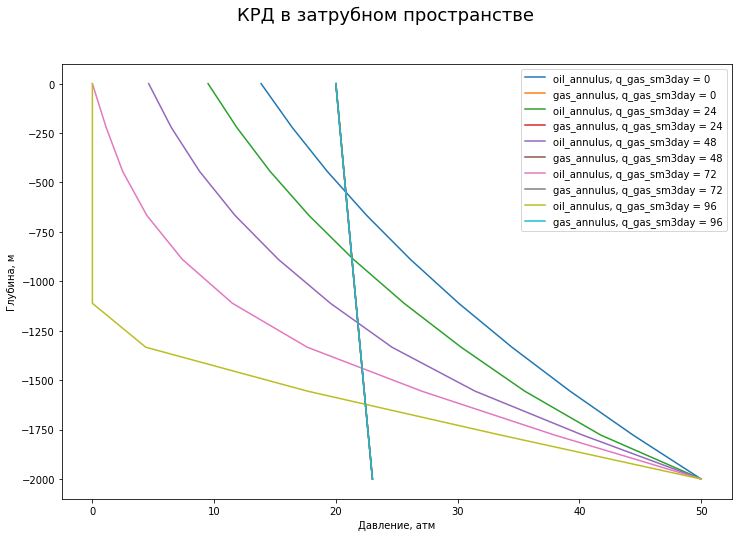

In [10]:
pipeline_data_oil_annulus['q_gas_sm3day'] = 0
fig = plt.figure()
for i in range(0, 100, 24):
    vba_result_oil_annulus, vba_result_gas_annulus, this_hdyn_m, qgas_m3day = calc_annulus_with_sep(pvt_str_data_oil_annulus,
                                                                                           pipeline_data_oil_annulus, 20,
                                                                                    ksep_d=0.7,
                                                                                                qliq_sm3day=50, 
                                                                                            fw_perc=i
                                                                                          )
    plt.plot(vba_result_oil_annulus['p,atma'], vba_result_oil_annulus.index * (-1), label = f"oil_annulus, q_gas_sm3day = {i}")
    plt.plot(vba_result_gas_annulus['p,atma'], vba_result_gas_annulus.index * (-1), label = f"gas_annulus, q_gas_sm3day = {i}")
    print(f"Для fw = {i} q_gas_sm3day = {qgas_m3day} динамический уровень, м = {this_hdyn_m}")
plt.legend(loc='upper right')
plt.xlabel('Давление, атм')
plt.ylabel('Глубина, м')
fig.suptitle(f"КРД в затрубном пространстве", fontsize = 18)
plt.show()

Теперь напишем последнюю функцию-обвязку, чтобы удобнее было проводить анализ чувствительности.

В словаре pipeline_data будем задавать дебит жидкости, обводненность, коэффициент сепарации.

Единственны параметр, который будет отдельно, это давление в затрубе

In [11]:
def sense_annulus(pipeline_data, pvt_str_data, parameter_sense,
                  range_sense, pvt_edit=False, p_calc_annulus_atma=20, debug_mode=False):
    """
    Функция для анализа чуствительности при расчете затрубного пространства
    pipeline_data: данные по потоку в НКТ, при этом
        diam_list_mm - гидравлический диаметр затрубного пространства
        qliq_sm3day - дебит жидкости на поверхности
        fw_perc - обводненность
    parameter_sense - ключ для параметра чувствительности
    range_sense - диапазон изменения параметр
    pvt_edit - флаг, если False, то parameter_sense для pipeline_data
                        если True, то parameter_sense для pvt_str_data
    p_calc_annulus_atma - давление в затрубе (примерно равно линейному)
    """
    if debug_mode:
        print('\nlevel3: sense_annulus init \npvt_str_data, pipeline_data')
        print(pvt_str_data)
        print(pipeline_data)
    
    fig = plt.figure()
    
    for i in range_sense: #будем последовательно менять либо PVT свойства либо свойства потока
        if pvt_edit:
            pvt_str_data[parameter_sense] = i
            pipeline_data['str_PVT'] = UniflocVBA.PVT_encode_string(**pvt_str_data)
        else:
            pipeline_data[parameter_sense] = i
        
        #создадим словарь PVT свойств для затрубного пространства
        pvt_str_data_oil_annulus = pvt_str_data.copy()
        pvt_str_data_oil_annulus['ksep_fr'] = 0
        pvt_str_data_oil_annulus['p_ksep_atma'] = -1
        pvt_str_data_oil_annulus['t_ksep_C'] = -1
        #создадим словарь общих данных для затрубного пространства
        pipeline_data_oil_annulus = pipeline_data.copy()
        pipeline_data_oil_annulus['qliq_sm3day'] = 0
        pipeline_data_oil_annulus['fw_perc'] = 0
        pipeline_data_oil_annulus['str_PVT'] = UniflocVBA.PVT_encode_string(**pvt_str_data_oil_annulus)
        
        if debug_mode:
            print('\nlevel2: sense_annulus \npvt_str_data_oil_annulus, pipeline_data_oil_annulus')
            print(pvt_str_data_oil_annulus)
            print(pipeline_data_oil_annulus)
        #найдем динамический уровень 
        vba_result_oil_annulus, vba_result_gas_annulus, this_hdyn_m, qgas_m3day = calc_annulus_with_sep(pvt_str_data_oil_annulus, 
                                                                                            pipeline_data_oil_annulus,
                                                                                            p_calc_annulus_atma, 
                                                                                            pvt_str_data['ksep_fr'], 
                                                                                            pipeline_data['qliq_sm3day'],
                                                                                            pipeline_data['fw_perc'], 
                                                                                                       debug_mode)
        #построим графики
        plt.plot(vba_result_oil_annulus['p,atma'], vba_result_oil_annulus.index * (-1),
                 label = f"oil_annulus, {parameter_sense} = {i}")
        plt.plot(vba_result_gas_annulus['p,atma'], vba_result_gas_annulus.index * (-1),
                 label = f"gas_annulus, {parameter_sense} = {i}")
        
        print(f"Затруб: для {parameter_sense} = {i} Динамический уровень,м = {this_hdyn_m}; Расход газа, ст.м3/сут = {qgas_m3day}")
    
    
    plt.legend(loc='upper right')
    plt.xlabel('Давление, атм')
    plt.ylabel('Глубина, м')
    fig.suptitle(f"КРД в затрубном пространстве", fontsize = 18)
    plt.show()

Зададим PVT свойства для скважины

In [12]:
pvt_str_data = {"gamma_gas":0.6,
"gamma_oil":0.86,
"gamma_wat":1,
"rsb_m3m3":70,
"rp_m3m3":-1,
"pb_atma":-1,
"tres_C":90,
"bob_m3m3":-1,
"muob_cP":-1,
"PVTcorr":0,
"ksep_fr":0.5, 
"p_ksep_atma":-1, #давление сепарации будет всегда совпадать с давлением на входе в трубу, тут можно не выставлять значение
"t_ksep_C":-1, #температура сепарации будет всегда совпадать с температурой на входе в трубу, тут можно не выставлять значение
"gas_only":False
               }

Исходные данные, описывающие работу скважины с ЭЦН и сепаратором

In [13]:
pipeline_data = {"p_calc_from_atma": 50, #давление в начале трубе совпадает с давлением сепарации
"t_calc_from_C": 50, #температура в начале трубе совпадает с температурой сепарации
"t_val":20, #температура на устье
"h_list_m" : 2500,
"diam_list_mm" : 50, #гидравлический диаметр затрубого пространства (т.е. разница между вн. диаметром обсадной колонные и внешним НКТ)
"qliq_sm3day" : 20, #дебит жидкости на поверхности
"fw_perc":0, #обводненность в потоке, в затрубе будет 0
"q_gas_sm3day":-1, #расход газа в затрубе, данное значение будет рассчитываться с учетом сепарации
"str_PVT":UniflocVBA.PVT_encode_string(**pvt_str_data),
"calc_flow_direction":0, #считаем всегда снизу-вверх, поток тоже снизу-вверх
"hydr_corr":0,
"temp_method":1,
"c_calibr":1,
"roughness_m":0.0001,
"out_curves":2, #нужен вывод распределения давления, не нужно ставить 0 или 1
"out_curves_num_points":10}

Проведем расчет при различных дебитах

На графике видно, чем больше дебит, тем больше свободного газа поступает в затруб

При дебите 300 м3/сут происходит фонтанирование через затруб, нужен расчет по другому алгоритму

Затруб: для qliq_sm3day = 10 Динамический уровень,м = (-2093.7932384924106,); Расход газа, ст.м3/сут = 242.34517203233486
Затруб: для qliq_sm3day = 50 Динамический уровень,м = (-1824.9580426431564,); Расход газа, ст.м3/сут = 1211.7258601616747
Затруб: для qliq_sm3day = 100 Динамический уровень,м = (-1242.2387803781203,); Расход газа, ст.м3/сут = 2423.4517203233495
Обнаружен фонтан через затруб для qgas_sm3day = 7270.355160970047
Затруб: для qliq_sm3day = 300 Динамический уровень,м = (237.95554493612227,); Расход газа, ст.м3/сут = 7270.355160970047


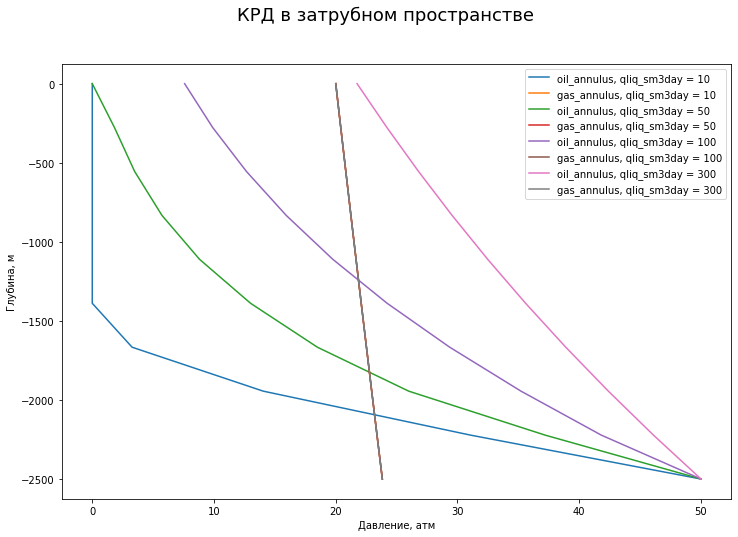

In [14]:
sense_annulus(pipeline_data.copy(), pvt_str_data.copy(), 'qliq_sm3day', [10,50,100,300], pvt_edit=False, debug_mode=False)

Зависимость динамического уровня от коэффициента сепарации

Затруб: для ksep_fr = 0 Динамический уровень,м = (-2164.8439294181676,); Расход газа, ст.м3/сут = 0.0
Затруб: для ksep_fr = 0.25 Динамический уровень,м = (-2094.1592509795773,); Расход газа, ст.м3/сут = 241.04815900003695
Затруб: для ksep_fr = 0.5 Динамический уровень,м = (-2030.4898889869714,); Расход газа, ст.м3/сут = 484.6903440646697
Затруб: для ksep_fr = 1 Динамический уровень,м = (-1904.3934251011187,); Расход газа, ст.м3/сут = 973.8871844902955


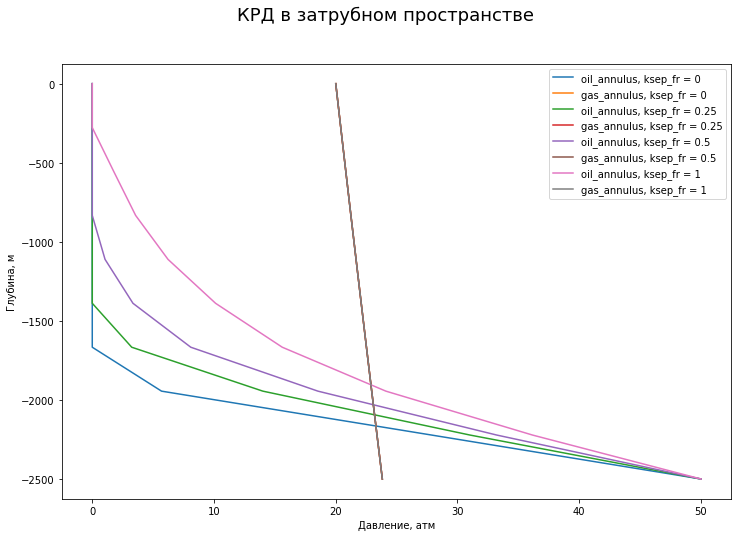

In [15]:
sense_annulus(pipeline_data.copy(), pvt_str_data.copy(), 'ksep_fr', [0,0.25,0.5,1], pvt_edit=True, debug_mode=False)

Зависимость от газосодержания

Затруб: для rsb_m3m3 = 50 Динамический уровень,м = (-2082.4781559712665,); Расход газа, ст.м3/сут = 284.7486410330062
Затруб: для rsb_m3m3 = 100 Динамический уровень,м = (-1958.2000480014506,); Расход газа, ст.м3/сут = 784.677019120441
Затруб: для rsb_m3m3 = 300 Динамический уровень,м = (-1075.106125876198,); Расход газа, ст.м3/сут = 2784.2567488383575


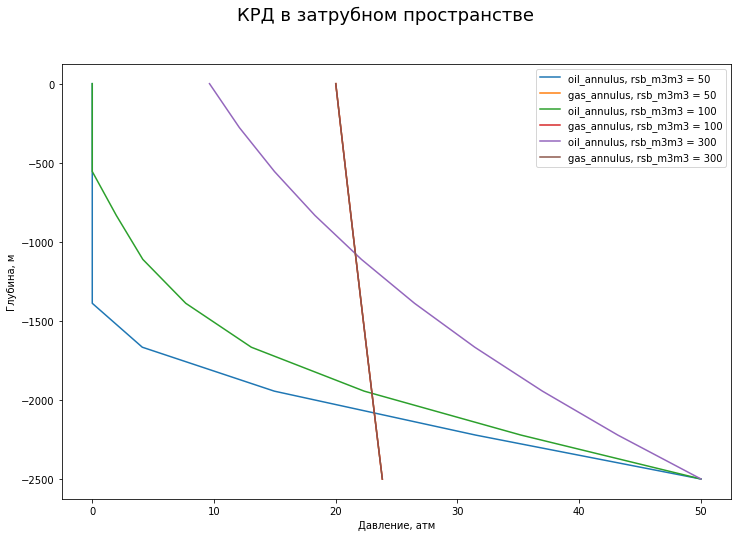

In [16]:
sense_annulus(pipeline_data.copy(), pvt_str_data.copy(), 'rsb_m3m3', [50,100,300], pvt_edit=True, debug_mode=False)

Чем ниже давление на приеме, тем сильнее газлифтный эффект в затрубе

При большом давлении на приеме, выше давления насыщения, в затрубе будет чистая нефть без газа

Затруб: для p_calc_from_atma = 30 Динамический уровень,м = (-2365.2520970427345,); Расход газа, ст.м3/сут = 583.6776971100394
Затруб: для p_calc_from_atma = 60 Динамический уровень,м = (-1887.025230532773,); Расход газа, ст.м3/сут = 431.8896726891878
Затруб: для p_calc_from_atma = 90 Динамический уровень,м = (-1514.8929980598539,); Расход газа, ст.м3/сут = 262.88921137144746
Затруб: для p_calc_from_atma = 120 Динамический уровень,м = (-1203.5811624292294,); Расход газа, ст.м3/сут = 78.56479121281309
Затруб: для p_calc_from_atma = 170 Динамический уровень,м = (-580.4754834482604,); Расход газа, ст.м3/сут = 0.0


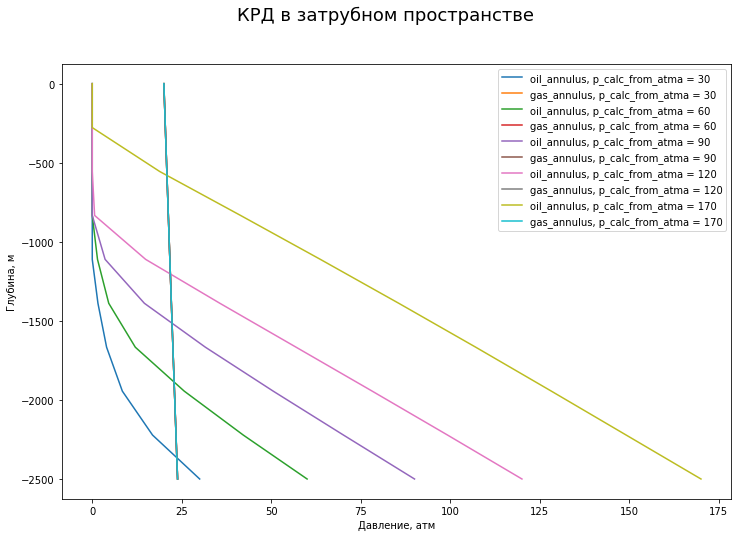

In [17]:
sense_annulus(pipeline_data.copy(), pvt_str_data.copy(), 'p_calc_from_atma', [30, 60,90,120, 170], pvt_edit=False, debug_mode=False)